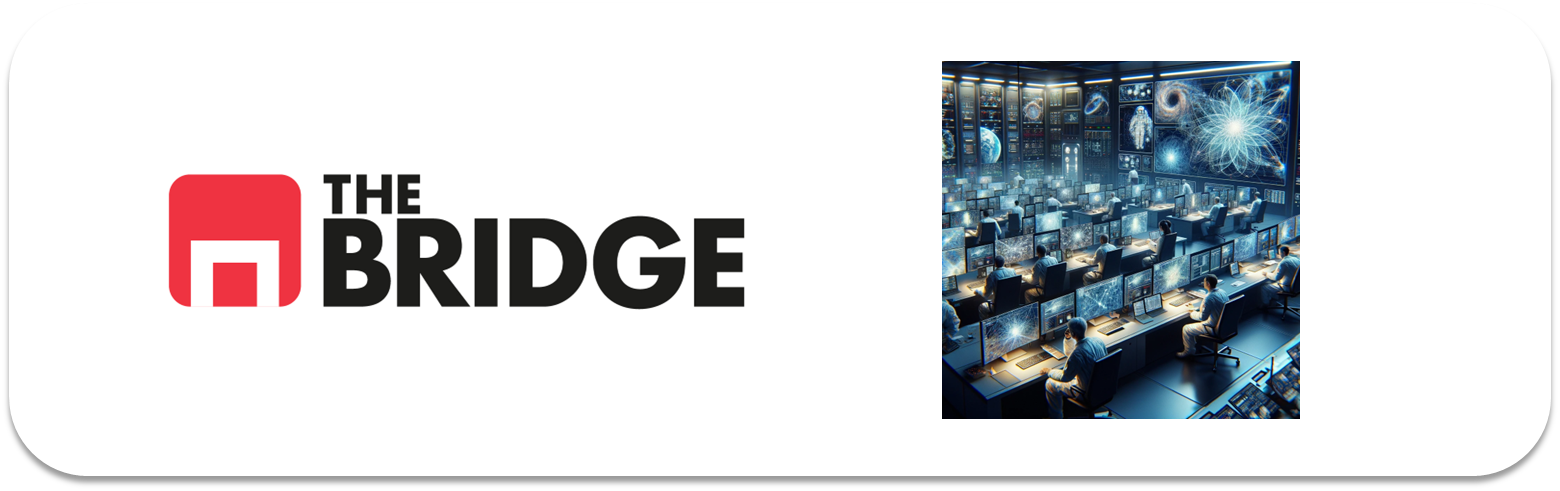

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



### Funciones y preparación de datos (código replicado de la solución del ejercicio de la primera unidad)

In [2]:
### Carga de datos y preparación obtenidas del ejercicio de la unidad 1:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"


*Introducimos un parametro de control de la resolución, inicialmente a 32, pero que podamos tocar sin cambiar nada del resto del código para poder probar otras resoluciones*

In [3]:
IMG_WIDTH = IMG_HEIGHT = 75

In [ ]:
def read_data(directorio, reshape_dim = (IMG_WIDTH,IMG_HEIGHT)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])


In [ ]:
X_train, y_train = read_data(TRAIN_PATH)
X_test, y_test = read_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


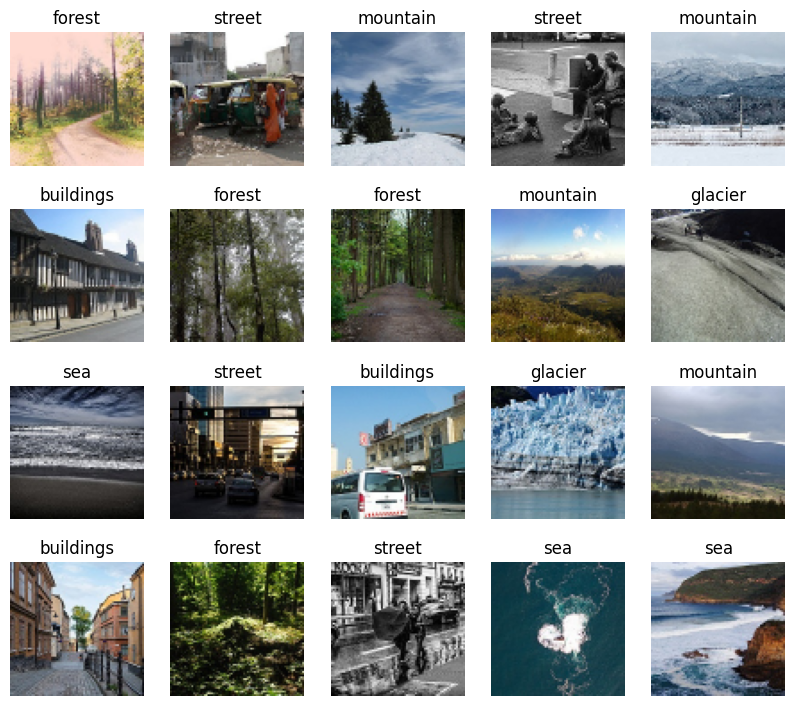

In [8]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [9]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
# np.savez(ROOT_PATH + 'data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

In [ ]:
# data = np.load(ROOT_PATH + 'data.npz')

# X_train = data['X_train']
# X_test = data['X_test']
# y_train = data['y_train']
# y_test = data['y_test']

### Seleccion del modelo a transferir y tunear


*Escogemos el modelo de [Inception V3](https://arxiv.org/abs/1512.00567) el que tiene las supercapas convolucionales para hacer transfer learning*

In [11]:
from keras.applications import InceptionV3

*Si investigas en la documentación del modelo verás que no puede admite resoluciones de entrada inferiores a 75x75*

### Transfer Learning

*Para el transfer learning vamos a usar una cabeza con una única capa densa con tantas unidades como el aplanamiento de las imagenes, es decir dependiendo de la resolución con la que hayamos cargado las imágenes al principio así tendremos una cantidad u otra de unidades*

In [12]:
X_train.size

236823750

*El train tiene un tamaño más que considerable para aplicar un Adam y eso vamos a hacer, en principio sin tocar nada más*

In [19]:
IMG_WIDTH = IMG_HEIGHT = 75
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False

# Capa de aplanado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)
    
    # Tantas unidades como el flatten de la salida de Inception -> 5625 features
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = "adam",
        loss = 'sparse_categorical_crossentropy', # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
        metrics = ['acc']
        )
    
    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 37, 37,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 35, 35,    │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 35, 35,    │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 17, 17,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 17, 17,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
type(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 37, 37,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 35, 35,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 35, 35,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 17, 17,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 17, 17,    │      5,120 │ max_pooling2d_12… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

NoneType

*Ahora vamos a configurar el resto de hiperparámetros, el batch_size, el número de épocas y el EarlyStopping*

In [21]:
instancias_train = len(X_train)
for i in range(1,5):
    print(f"Batch_size: {32*i}, num_steps_per_epoch: {round(instancias_train/(32*i))}")

Batch_size: 32, num_steps_per_epoch: 439
Batch_size: 64, num_steps_per_epoch: 219
Batch_size: 96, num_steps_per_epoch: 146
Batch_size: 128, num_steps_per_epoch: 110


*Podemos atrevernos hasta con batches de 128, para saber cuál usar vamos a hacer un entrenamiento de una época con cada uno y ver tiempos*

*Antes tendremos que convertir las etiquetas a números*

In [22]:
targets = pd.Series(y_train)

In [23]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Reutilizando la serie que creamos para ver la distribución del target
mapa

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [24]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [25]:
from time import time
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train, 
                        y_train_num,
                        batch_size = batch_size,
                        validation_split=0.2,
                        epochs=1,)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")


351/351 ━━━━━━━━━━━━━━━━━━━━ 37s 89ms/step - acc: 0.7027 - loss: 0.8620 - val_acc: 0.0973 - val_loss: 10.9332
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 37.781, tiempo 20 épocas: 755.62
176/176 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step - acc: 0.6819 - loss: 0.8781 - val_acc: 0.0859 - val_loss: 13.5024
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 31.804, tiempo 20 épocas: 636.0799999999999
117/117 ━━━━━━━━━━━━━━━━━━━━ 29s 210ms/step - acc: 0.6721 - loss: 0.9193 - val_acc: 0.1140 - val_loss: 16.9411
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 30.177, tiempo 20 épocas: 603.54
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - acc: 0.6760 - loss: 0.9057 - val_acc: 0.0873 - val_loss: 13.5920
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 29.95, tiempo 20 épocas: 599.0


*Vamos a por los 128 de batch size*

In [29]:
batch_size

128

In [30]:
earlyS = keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True)

In [31]:
from sklearn.utils import shuffle
X_train_s,y_train_s = shuffle(X_train, y_train_num)

In [32]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 251ms/step - acc: 0.6269 - loss: 1.0780 - val_acc: 0.7652 - val_loss: 0.6433
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - acc: 0.8187 - loss: 0.4831 - val_acc: 0.7813 - val_loss: 0.6060
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - acc: 0.8749 - loss: 0.3572 - val_acc: 0.7759 - val_loss: 0.6560
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - acc: 0.9140 - loss: 0.2629 - val_acc: 0.7781 - val_loss: 0.6595
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - acc: 0.9567 - loss: 0.1542 - val_acc: 0.7642 - val_loss: 0.7271
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 313ms/step - acc: 0.9745 - loss: 0.1011 - val_acc: 0.7759 - val_loss: 0.7441
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 334ms/step - acc: 0.9868 - loss: 0.0648 - val_acc: 0.7677 - val_loss: 0.8590
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 301ms/step - acc: 0.9889 - loss: 0.0548 - val_acc: 0.7716 - val_loss: 0.8549
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 308ms/

*Evaluamos*

In [33]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - acc: 0.7988 - loss: 0.5451


[0.6100484132766724, 0.7796666622161865]

*Un 78% que es un 2% mejor que la convolucional "sencilla", no es mucha ganancia para tanto armatoste. ¿Podríamos mejorar la cabeza decisora?*

*Completemos con el análisis del informe de clasificación y de la matriz de confusión*

In [34]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step


In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.83      0.82      0.82       437
      forest       0.93      0.95      0.94       474
     glacier       0.73      0.64      0.68       553
    mountain       0.68      0.70      0.69       525
         sea       0.71      0.79      0.75       510
      street       0.84      0.82      0.83       501

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



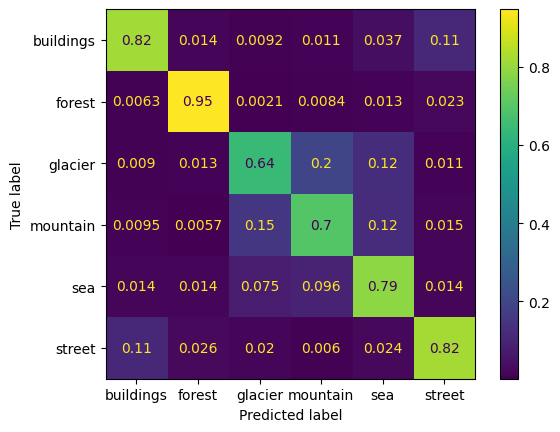

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

*Confunde montañas con glaciares y viceversa (las clases peor paradas), aunque también confunde el mar tanto con glaciar como con montaña. Es peor en montañas que el clasificador del ejercicio pero sensiblemente mejor en edificios y en glaciares (las dos clases "malas" del clasificador de los ejercicios). Al igual que el clasificador del ejercicio confunde calles con edificios.*

### Fine-Tuning

*Mantenemos la Inception V3**

In [39]:
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights=None, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
# for layer in base_model.layers:
#    layer.trainable = False

# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)
    
    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(base_model.input, x)

    model.compile(
        optimizer = "adam", 
        loss = 'sparse_categorical_crossentropy', 
        metrics = ['acc'])
    
    return model

# Observamos la arquitectura del modelo
model= prepare_model()
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_376 (Conv2D) │ (None, 37, 37,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │         96 │ conv2d_376[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_377 (Conv2D) │ (None, 35, 35,    │      9,216 │ activation_376[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_377[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_378 (Conv2D) │ (None, 35, 35,    │     18,432 │ activation_377[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_378[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 17, 17,    │          0 │ activation_378[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_379 (Conv2D) │ (None, 17, 17,    │      5,120 │ max_pooling2d_16… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_379[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_380 (Conv2D) │ (None, 15, 15,    │    138,240 │ activation_379[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_380[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 25,976,998 (99.09 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [40]:
from time import time
for batch_size in [32,64,96,128]:
    t_zero = time()
    model = prepare_model()
    history = model.fit(X_train_s, 
                        y_train_s,
                        batch_size = batch_size,
                        validation_split=0.2,
                        epochs=1,)
    tiempo = round(time() - t_zero, 3)
    print(f"batch_size: {batch_size}, num_steps: {len(X_train)/batch_size}, tiempo 1 epoca: {tiempo}, tiempo 20 épocas: {tiempo * 20}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 126s 288ms/step - acc: 0.4311 - loss: 1.8856 - val_acc: 0.1860 - val_loss: 3.5353
batch_size: 32, num_steps: 438.5625, tiempo 1 epoca: 126.864, tiempo 20 épocas: 2537.28
176/176 ━━━━━━━━━━━━━━━━━━━━ 121s 538ms/step - acc: 0.5029 - loss: 1.5467 - val_acc: 0.1614 - val_loss: 397.9680
batch_size: 64, num_steps: 219.28125, tiempo 1 epoca: 121.88, tiempo 20 épocas: 2437.6
117/117 ━━━━━━━━━━━━━━━━━━━━ 120s 816ms/step - acc: 0.5073 - loss: 1.2739 - val_acc: 0.2227 - val_loss: 1101.4716
batch_size: 96, num_steps: 146.1875, tiempo 1 epoca: 121.149, tiempo 20 épocas: 2422.98
88/88 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - acc: 0.5613 - loss: 1.1250 - val_acc: 0.1625 - val_loss: 507.8005
batch_size: 128, num_steps: 109.640625, tiempo 1 epoca: 119.401, tiempo 20 épocas: 2388.02


*Mantenemos el batch_size en 128*

*Lanzamos el fine-tuning y a esperar*

In [41]:
t_zero = time()
model = prepare_model()
history = model.fit(X_train_s, 
                    y_train_s,
                    batch_size = batch_size,
                    validation_split=0.2,
                    epochs=40,
                    callbacks = [earlyS])
tiempo = round(time() - t_zero, 3)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 113s 982ms/step - acc: 0.5862 - loss: 1.2536 - val_acc: 0.2369 - val_loss: 48.5775
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.6948 - loss: 0.9336 - val_acc: 0.7011 - val_loss: 0.8684
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - acc: 0.7799 - loss: 0.6189 - val_acc: 0.7004 - val_loss: 0.9125
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - acc: 0.8169 - loss: 0.5397 - val_acc: 0.7257 - val_loss: 0.7535
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - acc: 0.8255 - loss: 0.6109 - val_acc: 0.7595 - val_loss: 1.3432
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - acc: 0.7000 - loss: 1.1737 - val_acc: 0.1625 - val_loss: 69.8855
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - acc: 0.7226 - loss: 0.7492 - val_acc: 0.4097 - val_loss: 1.5911
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - acc: 0.7939 - loss: 0.5857 - val_acc: 0.6954 - val_loss: 0.9180
Epoch 9/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - acc: 0

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 [==============================] - 8s 81ms/step - loss: 0.5891 - acc: 0.8063


[0.589076042175293, 0.8063333630561829]

*Bueno, un 80%, 4 pp. mejor que el modelo con dos capas convolucionales,... ¿merece la pena el esfuerzo?*

In [ ]:
y_pred = [ np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 [==============================] - 12s 83ms/step


In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.80      0.78      0.79       437
      forest       0.92      0.94      0.93       474
     glacier       0.82      0.69      0.75       553
    mountain       0.75      0.80      0.78       525
         sea       0.71      0.88      0.79       510
      street       0.88      0.76      0.82       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



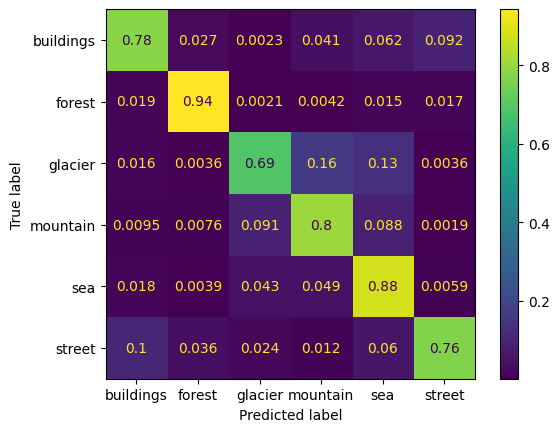

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

*El modelo completo ha mejorado en las que era peor el anterior pero a costa de empeorar en edificios y calles que ahora se confunden no solo entre ellos sino que un poco con todos.*

*El modelo fine-tuneado mejora en casi todo al modelo inicial, salvo en la detección de street y ligeramente en las montañas*

### EXTRA

*Vamos a repetir la parte de trasnfer learning pero utilizando aumentado de imágenes a ver si mejoramos algo más*

In [ ]:
ficheros = []
clases = []
for directorio in os.listdir(TRAIN_PATH):
    clase = directorio
    ficher = [TRAIN_PATH + directorio + "/" + fichero for fichero in os.listdir(TRAIN_PATH + directorio)]
    clases += [clase for fichero in ficher]
    ficheros += ficher
train_augmented = pd.DataFrame({"filename": ficheros,"category": clases})
train_augmented.head(10)

,filename,category
0,./data/seg_train/buildings/0.jpg,buildings
1,./data/seg_train/buildings/10006.jpg,buildings
2,./data/seg_train/buildings/1001.jpg,buildings
3,./data/seg_train/buildings/10014.jpg,buildings
4,./data/seg_train/buildings/10018.jpg,buildings
5,./data/seg_train/buildings/10029.jpg,buildings
6,./data/seg_train/buildings/10032.jpg,buildings
7,./data/seg_train/buildings/10056.jpg,buildings
8,./data/seg_train/buildings/1009.jpg,buildings
9,./data/seg_train/buildings/10113.jpg,buildings


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15, # Angulo de rotación
    # Escalado, ya nos escala las imágenes
    shear_range=0.1, # Inclina las imágenes, no es giro es inclinación como hacerlas "cursivas"
    zoom_range=0.2, # Zoom
    horizontal_flip=True, # giro horizontal o especular
    width_shift_range=0.1, # Desplazamiento horizontal de los pixeles
    height_shift_range=0.1 # Desplazamiento vertical de los píxeles
)

In [ ]:
train_df, validate_df = train_test_split(train_augmented,
                                         test_size=0.20,
                                         random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    x_col='filename',
    y_col='category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse', # Porque es binaria, si fuera multiclase y en un sólo valor -> "sparse" (otras configuraciones, ver la documentación)
    batch_size= batch_size
)

Found 11227 validated image filenames belonging to 6 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255) # Solo vamos a reescalar
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    x_col='filename',
    y_col='category',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='sparse',
    batch_size= batch_size
)

Found 2807 validated image filenames belonging to 6 classes.


In [ ]:
 from 
# Cargamos el modelo pre-entrenado
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Congelamos sus capas
for layer in base_model.layers:
    layer.trainable = False


# Capa de flatenizado de la salida del modelo base
def prepare_model(base_model = base_model): # Lo creamos así para poder reinicializarlo en cada reentrenamiento en ejercicios posteriores
    x = keras.layers.Flatten()(base_model.output)
    
    # Tantas unidades como el flatten de la salida de Inception
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)

    
    # Capa final de salida con 6 neuronas (una por clase) y activación softmax
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model
# Observamos la arquitectura del modelo

NameError: name 'InceptionV3' is not defined

In [ ]:
model = prepare_model()
history = model.fit(
    train_generator, 
    epochs= 40,
    validation_data=validation_generator,
    callbacks= earlyS
)

Epoch 1/40
88/88 [==============================] - 112s 1s/step - loss: 0.9341 - acc: 0.6634 - val_loss: 0.6794 - val_acc: 0.7467
Epoch 2/40
88/88 [==============================] - 35s 392ms/step - loss: 0.7067 - acc: 0.7380 - val_loss: 0.6873 - val_acc: 0.7367
Epoch 3/40
88/88 [==============================] - 35s 399ms/step - loss: 0.6708 - acc: 0.7472 - val_loss: 0.6732 - val_acc: 0.7431
Epoch 4/40
88/88 [==============================] - 36s 403ms/step - loss: 0.6577 - acc: 0.7561 - val_loss: 0.6340 - val_acc: 0.7617
Epoch 5/40
88/88 [==============================] - 36s 403ms/step - loss: 0.6355 - acc: 0.7653 - val_loss: 0.6124 - val_acc: 0.7667
Epoch 6/40
88/88 [==============================] - 36s 406ms/step - loss: 0.6218 - acc: 0.7657 - val_loss: 0.6103 - val_acc: 0.7631
Epoch 7/40
88/88 [==============================] - 35s 403ms/step - loss: 0.6040 - acc: 0.7734 - val_loss: 0.6149 - val_acc: 0.7695
Epoch 8/40
88/88 [==============================] - 36s 404ms/step - lo

In [ ]:
model.evaluate(X_test,y_test_num)

94/94 [==============================] - 8s 68ms/step - loss: 0.5597 - acc: 0.7973


[0.5596623420715332, 0.7973333597183228]